## EJECUTA ESTA CELDA PARA AUTENTICARTE CON TU CUENTA DE GMAIL

In [ ]:
!sudo /opt/miniconda/bin/pip install httplib2 apiclient oauth2client==1.5.2 ntplib tzlocal gspread google-api-python-client==1.6.2

In [1]:
from mooclib import *
import inspect, urllib
html, auth_code, userinfo = google_authenticate(PORT_NUMBER=8080)
html

CLICK ON THIS LINK TO AUTHENTICATE WITH YOUR GMAIL ACCOUNT
https://accounts.google.com/o/oauth2/auth?scope=profile+email&redirect_uri=http%3A%2F%2Flocalhost%3A8080&response_type=code&client_id=486275613361-7nk9ktukfcfjevfoe3tamjp0pmbjmprs.apps.googleusercontent.com&access_type=offline
waiting for authentication ...
code=4/ewC9UeTR3plQF2a_gvzEmhtgNceC39gOVcmw9347_925CY6dx4MZxx3fKSRTmTHUo-E44-CXaTjWrJvlnzOdibc&scope=https://www.googleapis.com/auth/userinfo.profile%20https://www.googleapis.com/auth/userinfo.email
No authentication


### EJERCICIO 1: Codificación de parámetros

Dado un dataset con $n$ columnas y una red neuronal con una sola capa de $h$ neuronas, los pesos de las conexiones y los términos de **bias** son los siguientes:

- $\mathbf{b}_1 \in \mathbb{R}^h$ son los términos de *bias* de la primera fase
- $\mathbf{W}_1 \in \mathbb{R}^{n \times h}$ son los pesos de las conexiones de la primera fase
- $b_1 \in \mathbb{R}$ es el término *bias* de la segunda fase
- $\mathbf{W}_2 \in \mathbb{R}^{h}$ son los pesos de las conexiones de la segunda fase

implementa las siguientes dos funciones para que codifiquen y descodifiquen los parámetros anteriores en un único vector de parámetros de forma que:

- `encode` devuelva un vector de $1+2h+h k$ elementos donde los primeros $h$ elementos corresponden a $\mathbf{b}_1$, el siguiente elmento al valor de $b_2$, los siguientes $nh$ elementos a los elementos de $\mathbf{W}_1$ linearizados y el resto de elementos a $\mathbf{W}_2$. Dado un array `numpy` `A`, usa la función `A.flatten()` para linearizarlo.

- `decode` acepte un vector como el anterior y extraiga los elementos $\mathbf{b}_1, b_2, \mathbf{W}_1$ y $\mathbf{W}_2$. Dado un array `numpy` `A`, usa la función `A.reshape` para _deslinearizarlo_


In [2]:
def encode(b1, b2, W1, W2): 
    encoded_params = np.concatenate([b1, [b2], W1.flatten(), W2.flatten()])
    return encoded_params

def decode(params, nb_cols, h_units):
    b1 = params[:h_units]
    b2 = params[h_units]
    W1 = params[h_units+1 : h_units + 1 + nb_cols*h_units].reshape(nb_cols, h_units)
    W2 = params[h_units + 1 + nb_cols*h_units: ].reshape(h_units, 1)
    return b1, b2, W1, W2

import urllib, inspect
src1 = urllib.quote_plus(inspect.getsource(encode)+"\n"+\
                         inspect.getsource(decode))

comprueba tu código

In [3]:
def random_params(nb_cols, h_units):
    W1 = np.random.random(size=(nb_cols,h_units))
    b1 = np.random.random(size=h_units)

    W2 = np.random.random(size=(h_units,1))
    b2 = np.random.random()
    return b1,b2,W1,W2
import numpy as np
b1, b2, W1, W2 = random_params(3,4)
print "shapes", b1.shape, b2, W1.shape, W2.shape
params = encode(b1,b2,W1,W2)
print "encoded params", params
eb1, eb2, eW1, eW2 = decode(params, 3,4) 
print "ALL OK?", len(params) == 21 and np.allclose(eb1,b1) and np.allclose(eb2,b2) and np.allclose(eW1, W1) and np.allclose(eW2, W2)


shapes (4,) 0.943007771901 (3, 4) (4, 1)
encoded params [0.94778114 0.32595577 0.73953602 0.41202719 0.94300777 0.31083038
 0.61345464 0.78433908 0.39359518 0.6781302  0.54160332 0.0649277
 0.60011609 0.13985794 0.62859155 0.31679155 0.83517168 0.42243613
 0.05101374 0.0795417  0.41997409]
ALL OK? True


#### evaluate your answer before submitting:

In [4]:
!./run CHECK_SOLUTION PS4_1 $src1

checking for 2 columns and 2 hidden units
checking for 1 columns and 4 hidden units
checking for 3 columns and 7 hidden units
checking for 3 columns and 9 hidden units
checking for 1 columns and 3 hidden units
evaluation result CORRECT


#### submit your answer (you must be connected to internet)

In [5]:
!./run SUBMIT_SOLUTION PS4_1 $src1

connecting ... registering submission for johanyepes@gmail.com ...
checking for 1 columns and 3 hidden units
checking for 3 columns and 2 hidden units
checking for 2 columns and 9 hidden units
checking for 3 columns and 2 hidden units
checking for 1 columns and 8 hidden units
your submissions sheet is https://docs.google.com/spreadsheets/d/1DLd93QfjZBJi20J-SE6-NSKtNaGtvKEawyPD03luawA
----
evaluation result CORRECT , submission registered


### EJERCICIO 2: Funciones de estimación de probabilidad y coste (con regularización)

Dada una neuronal de una sola capa, implementa:
- la función de estimación de probabilidad a la clase 1 de cualquier dato ($\hat{y}$) 
- la función de coste ($J$) 

según la siguiente definición

Para realizar la predicción para un solo elemento:

$$\hat{y} = g(\mathbf{W}_2 \cdot \tanh(\mathbf{x^T} \cdot \mathbf{W}_1 + \mathbf{b}_1) + b_2)$$

Para todos los elementos:

$$\hat{y} = g(\tanh(\mathbf{X} \cdot \mathbf{W}_1 + \mathbf{b}_1) \cdot \mathbf{W}_2 + b_2)$$

$$J(\mathbf{b}_1, b_2, \mathbf{W}_1, \mathbf{W}_2) = \frac{1}{m}\sum_{i=0}^{m-1} (\hat{y}^{(i)}-y^{(i)})^2 + \lambda \left[ || \mathbf{b}_1||^2 + b_2^2 + ||\mathbf{W}_1||^2 + ||\mathbf{W}_2||^2\right]$$

observa que la función de coste contiene un conjunto de términos regulados por $\lambda$ (y que están fuera de la sumatoria). Dado un vector o matriz $\mathbf{T}$, su norma al cuadrado se denota por $||\mathbf{T}||^2 \in \mathbb{R}$ y se calcula elevando todos sus elementos al cuadrado y obteniendo su suma. Este $\lambda$ es el argumento `reg` de la función `cost`.

el argumento `params` contiene el vector de parámetros según lo generaría la función `encode` del ejercicio anterior, con lo que tendrás que llamar a `decode` dentro de tu implementación para obtener los pesos de las conexiones y los términos de bias.

la función `y_hat` ha de funcionar con una matriz `X` en el que en cada fila hay un dato y devolver un vector con la estiamción de probabilidad de cada dato. **ESTE VECTOR HA DE TENER UNA DIMENSION** (`len(shape)`=1)

la función $tanh$ la tienes `numpy` como `np.tanh`

In [24]:
def decode(params, nb_cols, h_units):
    b1 = params[:h_units]
    b2 = params[h_units]
    W1 = params[h_units+1 : h_units + 1 + nb_cols*h_units].reshape(nb_cols, h_units)
    W2 = params[h_units + 1 + nb_cols*h_units: ].reshape(h_units, 1)
    return b1, b2, W1, W2

def y_hat(params, nb_cols, h_units, X):
    def sigm(x):
        return 1/(1+np.exp(-x))
    
    b1,b2,W1,W2 = decode(params, nb_cols, h_units)
    result = sigm(np.tanh(X.dot(W1) + b1).dot(W2) + b2).flatten()
    return result

def cost(X, y, params, reg, nb_cols, h_units):
    c = np.mean((y_hat(params, nb_cols, h_units, X) - y)**2) + reg * np.sum(params**2)
    return c

import urllib, inspect
src2 = urllib.quote_plus(inspect.getsource(decode)+"\n"+\
                         inspect.getsource(y_hat)+"\n"+\
                         inspect.getsource(cost))

comprueba tu código. calculamos $\sum \hat{y}$ para todos los elementos del dataset y también $J$. los valores esperados son 90.792 y 58.006 respectivamente. No te olvides de **EJECUTAR LA CELDA CON TU SOLUCIÓN DEL EJERCICIO 1**

In [23]:
import numpy as np
data = np.loadtxt("data/logregdata.csv", delimiter=",", skiprows=1)
X,y = data[:,:2], data[:,2]

print X.T.shape
h_units=4
cols = X.shape[1]
b1, b2, W1, W2 = np.ones(h_units), 2, np.ones((cols, h_units))*3, np.ones((h_units,1))*4
params = encode(b1,b2,W1,W2)
print "sum y_hat", np.sum(y_hat(params, cols, h_units, X))
print "cost     ", cost(X,y,params,0.4, cols, h_units )

(2, 100)
sum y_hat (100,)
[2.53420496e-06 9.99999978e-01 9.99999984e-01 9.99999954e-01
 9.99999980e-01 7.77049319e-01 1.45402706e-04 9.99999983e-01
 9.99990914e-01 9.99999983e-01 9.99999984e-01 9.99999806e-01
 9.99999985e-01 9.99999792e-01 9.99999985e-01 9.99999985e-01
 9.99939758e-01 2.69547733e-05 9.99999931e-01 9.99999978e-01
 9.99999972e-01 9.99999985e-01 9.99999968e-01 9.99999981e-01
 9.99999985e-01 9.99998552e-01 9.99999985e-01 9.99999984e-01
 9.99999985e-01 9.99999985e-01 9.99999983e-01 1.04329013e-06
 9.99999984e-01 9.99999985e-01 9.99999984e-01 9.99999985e-01
 9.99999965e-01 9.99999908e-01 9.99999969e-01 9.99999984e-01
 9.99999985e-01 2.42438625e-06 9.99999985e-01 1.45492044e-02
 9.99999295e-01 9.99999985e-01 9.99999985e-01 9.99999985e-01
 9.99999985e-01 9.99999984e-01 9.99809406e-01 9.99999983e-01
 9.99999984e-01 9.99999976e-01 9.99999981e-01 9.99999984e-01
 9.99999985e-01 9.99999975e-01 1.25419953e-06 9.99999983e-01
 9.99999985e-01 9.99999984e-01 9.99999985e-01 9.99999985e-0

#### evaluate your answer before submitting:

In [39]:
!./run CHECK_SOLUTION PS4_2 $src2

evaluation result CORRECT


#### submit your answer (you must be connected to internet)

In [8]:
!./run SUBMIT_SOLUTION PS4_2 $src2

connecting ... registering submission for johanyepes@gmail.com ...
your submissions sheet is https://docs.google.com/spreadsheets/d/1DLd93QfjZBJi20J-SE6-NSKtNaGtvKEawyPD03luawA
----
evaluation result CORRECT , submission registered


### EJERCICIO 3: Organización API `sklearn`

Organiza el código de los ejercicios anteriores para que esté conforme con el API de predicción de `sklearn`. En concreto:

- el constructor de la clase `SLP` acepta un parámetro que indica el número de neuronas de la capa intermedia y otro el parámetro de regularización $\lambda$. El tercer parámetro permite al usuario fijar qué parámetros iniciales se usan en el minimizador. Fíjate cómo la función `fit` los usa, o los inicializa aleatoriamente si no están definidos. 
- las dos primeras variables se guardan en variables de instancia como `self.h_units` y `self.reg` respectivamente y por eso desaparecen de los argumentos de las funciones correspondientes.
- la minimización del método `fit` usa `self.init_params` como valores iniciales de los parámetros. Esos valores se inicializan en el constructor
- una vez realizada la minización en el método `fit`, el vector codificado de parámetros obtenidos se guarda en la variable de instancia `self.params`
- la función `y_hat` ha de funcionar con una matrix en la que en cada fila hay un dato, y ha de devolver un vector con valor por cada dato, al igual que en el ejercicio anterior

Observa, adicionalmente, como la función `predict` aplica un umbral a $\hat{y}$


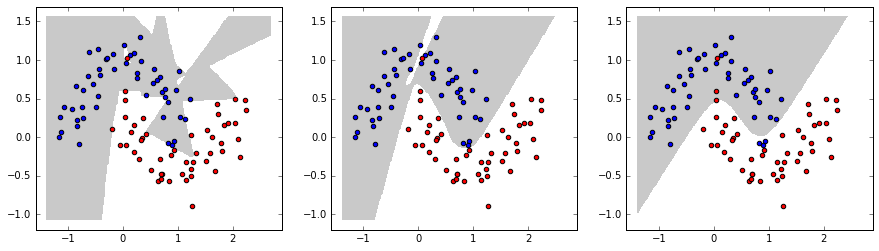

In [4]:
from IPython.display import Image
Image(filename='imgs/slp1.png')

In [9]:
def SLP(**args): # hack for inspect to work with classes
    from scipy.optimize import minimize
    import numpy as np
    
    class SLP_class:

        def __init__(self, h_units, reg=0, init_params=None):
            self.h_units = h_units
            self.reg     = reg
            self.init_params = init_params

        def sigm(self, x):
            return 1/(1+np.exp(-x))
        
        def encode(self, b1, b2, W1, W2): 
            return np.concatenate([b1, [b2], W1.flatten(), W2.flatten()])
        
        def decode(self, params, nb_cols):
            b1 = params[:self.h_units]
            b2 = params[self.h_units]
            W1 = params[self.h_units + 1 : self.h_units + 1 + nb_cols * self.h_units].reshape(nb_cols, self.h_units)
            W2 = params[self.h_units + 1 + nb_cols * self.h_units: ].reshape(self.h_units, 1)
            return b1, b2, W1, W2

        def y_hat(self, X, params):
            cols = X.shape[1]
            b1, b2, W1, W2 = self.decode(params, cols)
            return self.sigm(np.tanh(X.dot(W1) + b1).dot(W2) + b2).flatten()

        def fit(self, X,y, verbose=False):

            self.init_params = np.random.random(1+self.h_units*2+self.h_units*X.shape[1]) \
                               if self.init_params is None else self.init_params

            # p -> encoded params
            def cost(p):
                return np.mean((self.y_hat(X, p) - y)**2) + self.reg * np.sum(p**2)

            r = minimize(cost, self.init_params, method="BFGS")
            self.params = r.x

        def predict(self, X):
            return (self.y_hat(X, self.params)>.5)*1

        def score(self, X,y):
            return np.sum(self.predict(X)==y)*1./len(X)
        
    return SLP_class(**args)

import urllib, inspect
src3 = urllib.quote_plus(inspect.getsource(SLP))

Comprueba tu código, debería de darte similar a la figura anterior

(100, 2) (100,)


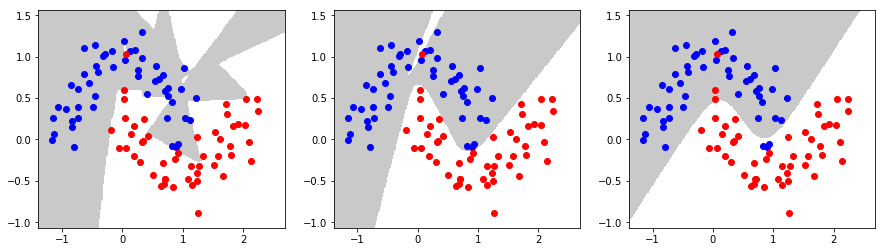

In [10]:
from sklearn.datasets import *
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

def plot_2Ddata_with_boundary(predict,X,y):
    n = 200
    mins,maxs = np.min(X,axis=0), np.max(X,axis=0)
    mins -= np.abs(mins)*.2
    maxs += np.abs(maxs)*.2
    d0 = np.linspace(mins[0], maxs[0],n)
    d1 = np.linspace(mins[1], maxs[1],n)
    gd0,gd1 = np.meshgrid(d0,d1)
    D = np.hstack((gd0.reshape(-1,1), gd1.reshape(-1,1)))
    p = (predict(D)*1.).reshape((n,n))
    plt.contourf(gd0,gd1,p, levels=[-0.1,0.5], alpha=0.5, cmap=plt.cm.Greys)
    plt.scatter(X[y==0][:,0], X[y==0][:,1], c="blue")
    plt.scatter(X[y==1][:,0], X[y==1][:,1], c="red")

data = np.loadtxt("data/logregdata.csv", delimiter=",", skiprows=1)
X,y = data[:,:2], data[:,2]
print X.shape, y.shape
plt.figure(figsize=(15,4))
ip = np.array([ 0.689641  ,  0.8786391 ,  0.95659198,  0.47073749,  0.24074414,
        0.78959323,  0.54514714,  0.89902493,  0.36378902,  0.17810766,
        0.39348206,  0.83286214,  0.18947855,  0.12043622,  0.59037094,
        0.74393984,  0.17897618,  0.92972173,  0.14988048,  0.08396469,
        0.55636004,  0.86317963,  0.07162948,  0.86307293,  0.06824969,
        0.55192334,  0.51150851,  0.57932144,  0.32561662,  0.51480763,
        0.11084518,  0.21689325,  0.39686863,  0.58469945,  0.32392055,
        0.86308447,  0.24791053,  0.60489576,  0.90859133,  0.11697256,
        0.74434179])

plt.subplot(131); slp = SLP(h_units=10, reg=0., init_params=ip); slp.fit(X,y); plot_2Ddata_with_boundary(slp.predict, X,y)
plt.subplot(132); slp = SLP(h_units=10, reg=1e-6, init_params=ip); slp.fit(X,y); plot_2Ddata_with_boundary(slp.predict, X,y)
plt.subplot(133); slp = SLP(h_units=10, reg=1e-3, init_params=ip); slp.fit(X,y); plot_2Ddata_with_boundary(slp.predict, X,y)

#### evaluate your answer before submitting:

In [11]:
!./run CHECK_SOLUTION PS4_3 $src3

evaluation result CORRECT


#### submit your answer (you must be connected to internet)

In [12]:
!./run SUBMIT_SOLUTION PS4_3 $src3

connecting ... registering submission for johanyepes@gmail.com ...
your submissions sheet is https://docs.google.com/spreadsheets/d/1DLd93QfjZBJi20J-SE6-NSKtNaGtvKEawyPD03luawA
----
evaluation result CORRECT , submission registered


### EJERCICIO 4: Regularización

completa la siguiente función para que:

- Extraiga los primeros `n` elementos de `X` e `y` en las variables `Xtr` e `ytr`.
- Cree y entrene tres redes neuronales con:
   - 10 `h_units`
   - `reg` igual a $0$, $10^{-5}$ y $10^{-3}$ respectivamente.
   - usando el `init_params` pasado como argumento en la propia función.
   
- El entrenamiento habrá de hacerse con `Xtr` e `ytr`.

In [13]:
def experiment(X,y, n, init_params):

    Xtr, ytr = X[:n], y[:n]

    slp1 = SLP(h_units=10, reg=0., init_params=init_params)
    slp1.fit(Xtr,ytr)
    
    slp2 = SLP(h_units=10, reg=10**-5, init_params=init_params)
    slp2.fit(Xtr,ytr)
    
    slp3 = SLP(h_units=10, reg=10**-3, init_params=init_params)
    slp3.fit(Xtr,ytr)
    
    return slp1, slp2, slp3

import urllib, inspect
src4 = urllib.quote_plus(inspect.getsource(experiment))

comprueba tu código. observa cómo las gráficas que se generan muestran cómo responde el clasificador a los datos de entrenamiento (los primeros 75 datos) y el resto de los datos (test). Los scores han de ser los siguientes:

- SLP1: 1.0 en TRAIN y 0.80 en TEST
- SLP2: 1.0 en TRAIN y 0.88 en TEST
- SLP3: 0.95 en TRAIN y 0.96 en TEST

In [ ]:
data = np.loadtxt("data/logregdata.csv", delimiter=",", skiprows=1)
X,y = data[:,:2], data[:,2]
np.random.seed(1022)
ip = np.array([ 0.689641  ,  0.8786391 ,  0.95659198,  0.47073749,  0.24074414,
        0.78959323,  0.54514714,  0.89902493,  0.36378902,  0.17810766,
        0.39348206,  0.83286214,  0.18947855,  0.12043622,  0.59037094,
        0.74393984,  0.17897618,  0.92972173,  0.14988048,  0.08396469,
        0.55636004,  0.86317963,  0.07162948,  0.86307293,  0.06824969,
        0.55192334,  0.51150851,  0.57932144,  0.32561662,  0.51480763,
        0.11084518,  0.21689325,  0.39686863,  0.58469945,  0.32392055,
        0.86308447,  0.24791053,  0.60489576,  0.90859133,  0.11697256,
        0.74434179])

n = 75
slp1, slp2, slp3 = experiment(X,y, 75, init_params=ip)
plt.figure(figsize=(15,6))
plt.subplot(231); plot_2Ddata_with_boundary(slp1.predict, X[:n],y[:n]); plt.title("SLP1 TRAIN score %.2f"%slp1.score(X[:n], y[:n]))
plt.subplot(232); plot_2Ddata_with_boundary(slp2.predict, X[:n],y[:n]); plt.title("SLP2 TRAIN score %.2f"%slp2.score(X[:n], y[:n]))
plt.subplot(233); plot_2Ddata_with_boundary(slp3.predict, X[:n],y[:n]); plt.title("SLP3 TRAIN score %.2f"%slp3.score(X[:n], y[:n]))

plt.subplot(234); plot_2Ddata_with_boundary(slp1.predict, X[n:],y[n:]); plt.title("SLP1 TEST score %.2f"%slp1.score(X[n:], y[n:]))
plt.subplot(235); plot_2Ddata_with_boundary(slp2.predict, X[n:],y[n:]); plt.title("SLP2 TEST score %.2f"%slp2.score(X[n:], y[n:]))
plt.subplot(236); plot_2Ddata_with_boundary(slp3.predict, X[n:],y[n:]); plt.title("SLP3 TEST score %.2f"%slp3.score(X[n:], y[n:]))

#### evaluate your answer before submitting:

In [17]:
!./run CHECK_SOLUTION PS4_4 $src4

checking first use case
checking second use case
evaluation result CORRECT


#### submit your answer (you must be connected to internet)

In [ ]:
!./run SUBMIT_SOLUTION PS4_4 $src4